In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import datetime
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from scipy.integrate import solve_ivp
from sklearn.model_selection import train_test_split

from models import BaseModel, Euler, RungeKutta4Same, RungeKutta4Diff
from datasets import HopfDataset, LorenzDataset
from utils import *

In [ ]:
# Deterministic initialization of each random processes
# It is a MUST for replicating the same results

seed = 42 
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Generation of points

Our learning set consists of an array with $N$ rows and $2d + n_{\text{params}}$ columns, where $d$ is the dimensionality of the system and $n_{\text{params}}$ is the number of parameters. Each row contains $[\vec{y}_n, \vec{y}_{n+1}, \vec{\theta}]^\top$.

In [ ]:
def generate_data(config):
    """Generates the learning set for a dynamical system.

    Args:
        config (Config): a configuration object to set parameters

    Raises:
        Exception: if the dynamical system's function is not implemented

    Returns:
        torch.tensor: learning set [*x*, params]
    """
    torch.manual_seed(seed)
    random_initial_points = torch.Tensor(config.n_points, config.n_dimensions).uniform_(-1,1).float()
    assert len(random_initial_points) == config.n_points

    # Random parameters
    # -- for Hopf
    if config.function == andronov_hopf_bifurcation:
        torch.manual_seed(seed)
        random_alpha = torch.hstack([torch.Tensor(config.n_gen_params).uniform_(-1,1).float(), torch.Tensor([-1, 0 ,1]).float()]) 
        random_parameters = torch.cartesian_prod(random_alpha)
        data_points = [item for i in range(2) for item in [f"x{i}",f"y{i}"] ]

    # -- for Lorenz
    elif config.function == lorenz:
        torch.manual_seed(seed)
        random_sigma = torch.hstack([torch.Tensor(config.n_gen_params).uniform_(9, 11).float(), torch.Tensor([9, 10 ,11]).float()]) 
        random_beta = torch.hstack([torch.Tensor(config.n_gen_params).uniform_(2/3, 14/3).float(), torch.Tensor([2/3, 8/3 ,14/3]).float()]) 
        random_rho = torch.hstack([torch.Tensor(config.n_gen_params).uniform_(27, 29).float(), torch.Tensor([27, 28 ,29]).float()]) 
        random_parameters = torch.cartesian_prod(random_sigma, random_beta, random_rho)
        data_points = [item for i in range(2) for item in [f"x{i}",f"y{i}",f"z{i}"] ]

    else:
        raise Exception('This function is not implemented.')

    dataset = []

    for input in tqdm(random_parameters):
        shape = random_initial_points.shape
        point = random_initial_points
        params_set = [input.numpy()] if 1==config.n_params else list(input.numpy())
        if config.method=="rk4":
            sol = solve_ivp(config.function, [0, config.time_step], point.flatten().numpy(),
                            args=(params_set), t_eval=[config.time_step])
            evolution = torch.tensor(sol.y.reshape(shape)).float()
        elif config.method=="euler":

            args = tuple([None] + [point.flatten().numpy()] + params_set)
            evolution = point + config.time_step * torch.tensor(config.function(*args).reshape(shape))

        else:
            raise Exception('This method is not implemented.')
        par_stack = torch.stack([input.unsqueeze(0) if 1==config.n_params else input for _ in range(config.n_points)])
        dataset.append(torch.cat([point, evolution, par_stack], dim=1))
    dataset = torch.cat(dataset)
    col_names = data_points + [f"par{i}" for i in range(config.n_params)]
    data = pd.DataFrame(dataset.numpy(), columns=col_names)
    data.to_parquet(f"data/{config.name}_{config.method}.parquet")
    return dataset

In [ ]:
class Config():
    def __init__(self, function, n_dimensions:int, n_params: int, n_points: int,
                time_step: float, n_gen_params: int, method: str, name:str):
        self.function = function
        self.n_dimensions = n_dimensions
        self.n_params = n_params
        self.time_step = time_step
        self.n_points = n_points
        self.n_gen_params = n_gen_params # uniformly generated parameters
        self.method = method
        self.name = name


In [ ]:
hopf_euler_config = Config(function=andronov_hopf_bifurcation, 
                    n_dimensions=2, 
                    n_params=1, 
                    n_points=1000,
                    time_step=0.01,
                    n_gen_params=5,
                    method="euler",
                    name="hopf")

hopf_rk4_config = Config(function=andronov_hopf_bifurcation, 
                    n_dimensions=2, 
                    n_params=1, 
                    n_points=1000,
                    time_step=0.01,
                    n_gen_params=5,
                    method="rk4",
                    name="hopf")

lorenz_euler_config = Config(function=lorenz, 
                    n_dimensions=3, 
                    n_params=3, 
                    n_points=1000,
                    time_step=0.01,
                    n_gen_params=5,
                    method="euler",
                    name="lorenz")

lorenz_rk4_config = Config(function=lorenz, 
                    n_dimensions=3, 
                    n_params=3, 
                    n_points=1000,
                    time_step=0.01,
                    n_gen_params=5,
                    method="rk4",
                    name="lorenz")

In [ ]:
%%time 
data = generate_data(hopf_euler_config)
data.shape

100%|██████████| 8/8 [00:00<00:00, 158.50it/s]


CPU times: user 103 ms, sys: 12.5 ms, total: 115 ms
Wall time: 1.08 s


torch.Size([8000, 5])

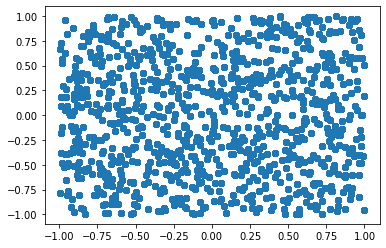

In [ ]:
#Visual example of the generted dataset
plt.scatter(data[:,0], data[:,1])

In [ ]:
%%time
data = generate_data(hopf_rk4_config)
data.shape

100%|██████████| 8/8 [00:00<00:00, 133.60it/s]

CPU times: user 81.9 ms, sys: 56.4 ms, total: 138 ms
Wall time: 89.4 ms


torch.Size([8000, 5])

In [ ]:
%%time
data = generate_data(lorenz_euler_config)
data.shape

100%|██████████| 512/512 [00:00<00:00, 2374.06it/s]


CPU times: user 347 ms, sys: 14.6 ms, total: 362 ms
Wall time: 354 ms


torch.Size([512000, 9])

In [ ]:
%%time
data = generate_data(lorenz_rk4_config)
data.shape

100%|██████████| 512/512 [00:01<00:00, 415.72it/s]


CPU times: user 1.41 s, sys: 1.21 s, total: 2.62 s
Wall time: 1.46 s


torch.Size([512000, 9])